In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-reviews/amazon_review_polarity_csv.tgz
/kaggle/input/amazon-reviews/train.csv
/kaggle/input/amazon-reviews/test.csv
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt


In [2]:
import csv
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [3]:
amazon_csv = "/kaggle/input/amazon-reviews/train.csv"

with open(amazon_csv, 'r') as csvfile:
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

First data point looks like this:

"2","Stuning even for the non-gamer","This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^"

Second data point looks like this:

"2","The best soundtrack ever to anything.","I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would 

In [4]:
def parsing_data(filename):
    
    sentences = []
    labels = []
    
    with open(filename, 'r') as file:
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            labels.append(0 if row[0] == 1 else 1)
            sentences.append(row[1])
        
    return sentences, labels

In [5]:
sentences, labels = parsing_data(amazon_csv)

print(f"examples: {len(sentences)}\n")

examples: 3600000



In [6]:
embedding_dim= 100
maxlen = 20
truncating = 'post'
padding = 'post'
oov_token = "<OOV>"
max_examples = 20000
training_split = 0.9

In [7]:
sentences_and_labels = list(zip(sentences, labels))
random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, max_examples)
sentences, labels = zip(*sentences_and_labels)

print(f"sentences = {len(sentences)} labels = {len(labels)}\n")

sentences = 20000 labels = 20000



In [8]:
def train_val_split(sentences, labels, training_split):
    train_size = int(len(sentences)*training_split)
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [9]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, training_split)

print(f"sentences for training {len(train_sentences)}\n")
print(f"labels for training{len(train_labels)}\n")
print(f"sentences for validation{len(val_sentences)}\n")
print(f"labels for validation {len(val_labels)}")

sentences for training 18000

labels for training18000

sentences for validation2000

labels for validation 2000


In [10]:
def fit_tokenizer(train_sentences, oov_token):
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [11]:
tokenizer = fit_tokenizer(train_sentences, oov_token)

word_index = tokenizer.word_index
vocab_size = len(word_index)

print(f"Vocab size:{vocab_size} \n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

Vocab size:11419 

<OOV> token included in vocabulary

index of word 'i' should be 15


In [12]:
def sequence_padding(sentences, tokenizer, padding, truncating, maxlen):      
    sequences = tokenizer.texts_to_sequences(sentences)  
    pad_trunc_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)  
    return pad_trunc_sequences

In [13]:
train_pad_trunc_seq = sequence_padding(train_sentences, tokenizer, padding, truncating, maxlen)
val_pad_trunc_seq = sequence_padding(val_sentences, tokenizer, padding, truncating, maxlen)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (18000, 20)

Padded and truncated validation sequences have shape: (2000, 20)


In [14]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [15]:
GLOVE_FILE = '../input/glove6b100dtxt/glove.6B.100d.txt'
my_dict = {}
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        my_dict[word] = coefs

In [16]:
test_word = 'ocean'
test_vector = my_dict[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word ocean looks like this:

[-5.5488e-01  3.4765e-01  1.1316e+00  1.3350e-01  4.8035e-01 -4.8530e-01
  2.6267e-01  5.6823e-01 -8.0506e-01 -9.4061e-02  2.1174e-01  2.3551e-01
  2.1247e-01 -4.6676e-01  4.8786e-01 -7.6312e-01 -8.9015e-04 -2.5848e-01
 -1.7698e-02 -6.5572e-02  3.9691e-01  4.3218e-01  9.8119e-01 -3.4214e-01
  1.7280e-01  1.0148e+00 -7.8283e-01  1.9244e-02  2.7627e-01 -6.0768e-01
 -1.4342e-01 -2.6839e-02 -2.1693e-01  2.9670e-01  2.4015e-01 -3.0766e-01
  2.3081e-01  4.8479e-02  4.3400e-01 -2.2981e-01 -1.1784e+00 -7.5073e-01
 -7.1644e-01 -9.0112e-02  9.8725e-01  1.1166e+00  1.8161e-01 -2.8353e-02
  3.3476e-02  5.3840e-01  1.8152e-02  4.5513e-01  2.6864e-01  5.5065e-01
 -4.5642e-02 -2.1594e+00  1.2931e-01 -5.4414e-01  1.7955e+00  5.6752e-01
 -5.9456e-01  1.0636e+00  6.8371e-02 -3.1427e-01  4.6764e-01  7.3519e-01
 -4.5162e-01 -4.1449e-01  8.4739e-01 -5.8426e-01  9.4224e-02  6.3878e-03
  1.0289e+00 -2.6392e-01 -3.7318e-01 -7.6389e-02  4.8541e-01  7.6963e-

In [17]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


In [18]:
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = my_dict.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [19]:
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    lstm1_dim = 64
    lstm2_dim = 32
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
        #tf.keras.layers.Dropout(0.2),
        #tf.keras.layers.Conv1D(32, 5, activation='relu'),
        #tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    return model

In [20]:
model = create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix)

history = model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, val_labels))

2022-07-20 16:03:01.323916: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-20 16:03:02.582984: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
563/563 [==============================] - 35s 49ms/step - loss: 0.0105 - accuracy: 0.9982 - val_loss: 1.0615e-05 - val_accuracy: 1.0000
Epoch 2/20
563/563 [==============================] - 25s 44ms/step - loss: 6.1280e-06 - accuracy: 1.0000 - val_loss: 3.3854e-06 - val_accuracy: 1.0000
Epoch 3/20
563/563 [==============================] - 26s 46ms/step - loss: 2.3689e-06 - accuracy: 1.0000 - val_loss: 1.5927e-06 - val_accuracy: 1.0000
Epoch 4/20
563/563 [==============================] - 25s 44ms/step - loss: 1.2134e-06 - accuracy: 1.0000 - val_loss: 8.8753e-07 - val_accuracy: 1.0000
Epoch 5/20
563/563 [==============================] - 26s 46ms/step - loss: 7.0774e-07 - accuracy: 1.0000 - val_loss: 5.4145e-07 - val_accuracy: 1.0000
Epoch 6/20
563/563 [==============================] - 26s 46ms/step - loss: 4.4324e-07 - accuracy: 1.0000 - val_loss: 3.4821e-07 - val_accuracy: 1.0000
Epoch 7/20
563/563 [==============================] - 25s 44ms/step - loss: 2.9020e-07 - acc

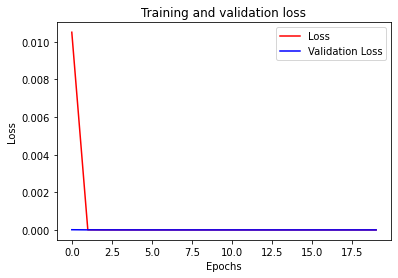

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = [*range(20)]
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

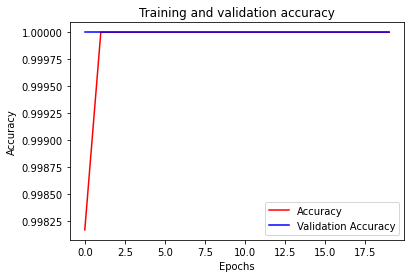

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()